# Evaluation Metrics for Search
* Notebook by Adam Lang
* Date 7/28/2024

# Evaluation Measures for Search
* It is important to understand the hierarchy of evaluation metrics used for search and recommendation systems.
* Many of these metrics are used in today's RAG-LLM pipelines to evaluate the search/retrieval component of the RAG-LLM application pipeline.
* The hierarchical breakdown of this is as follows:

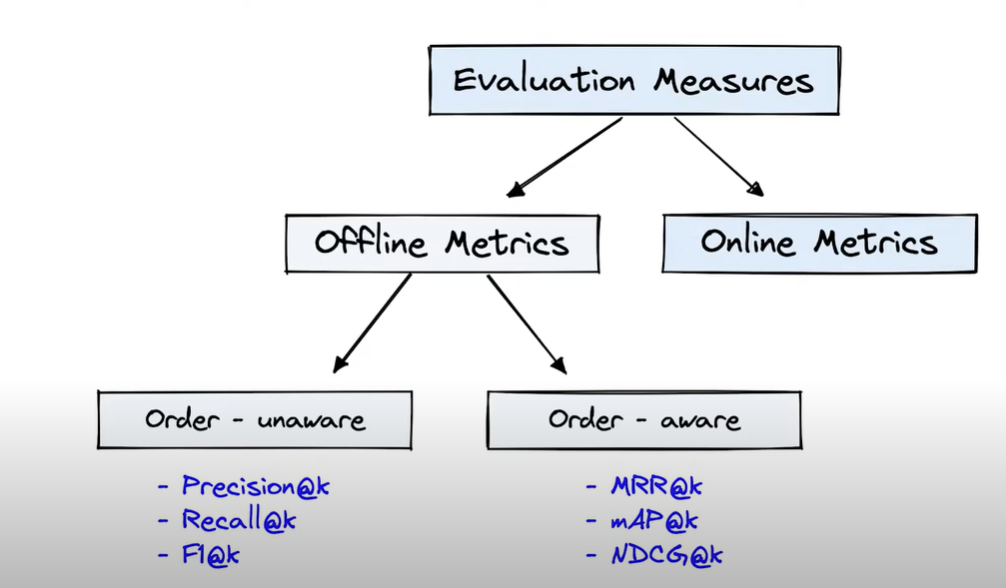

## Order Unaware vs. Aware
* This relates to whether the order of results has any impact on the final score.
* **Order Aware** - order is important
* **Order Unaware** - order NOT important

## Actual vs. Predicted Conditions
* Actual relevancy -- relevant to the dataset
* Predicted relevancy - most relevant to the actual relevancy
   * Confusion Matrix results are the best example of this.

# Search Metrics in Detail

## 1. `Recall@K`
* Equation is as follows:

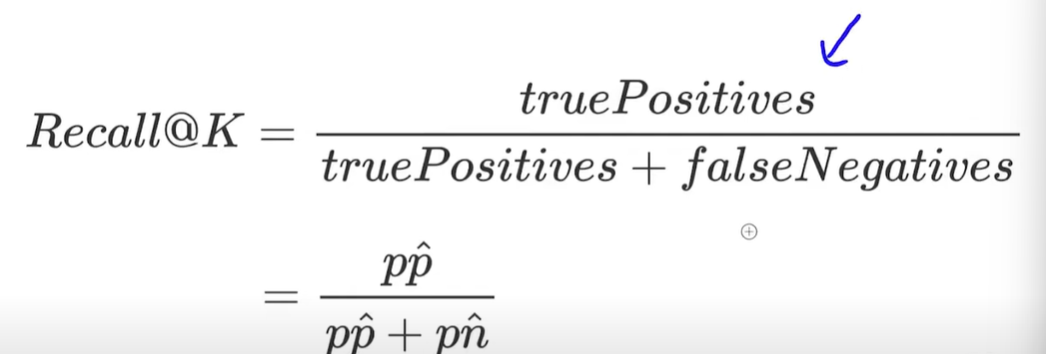

* This is the predicted positives that are also positives and divide that by the total number of positives in the dataset.
* Example of use:
   * `Recall@2` = pp / pp + pn = 1 / 1 + 3 = 0.25



In [1]:
## recall @k function
def recall(actual, predited, k):
  act_set = set(actual)
  pred_set = set(predicted[:k])
  result = round(len(act_set & pred_set) / float(len(act_set)), 2)

  return result

We can use some dummy data to demonstrate this:
* **actual** - actual values
* **predicted** - predicted values

We can now loop through and see what each `recall@k` would be.

In [2]:
## dummy data
actual = ['2', '4', '5', '7']
predicted = ['1', '2', '3', '4','5','6','7','8']
# loop through each possible k prediction
for k in range(1,9):
  print(f"Recall@{k} = {recall(actual, predicted, k)}")

Recall@1 = 0.0
Recall@2 = 0.25
Recall@3 = 0.25
Recall@4 = 0.5
Recall@5 = 0.75
Recall@6 = 0.75
Recall@7 = 1.0
Recall@8 = 1.0


Summary:
* We can see that the higher value of k has a higher recall rate.
* This very nicely demonstrates how recall is an **order unaware** metric, in that order does not matter.
* This is usually not a problem, however if you need to retrieve let's say the **topk = 3** which is common in retrieval systems then it is an obvious issue.

## 2. `MRR`
* Order aware metric.
* Equation as follows:

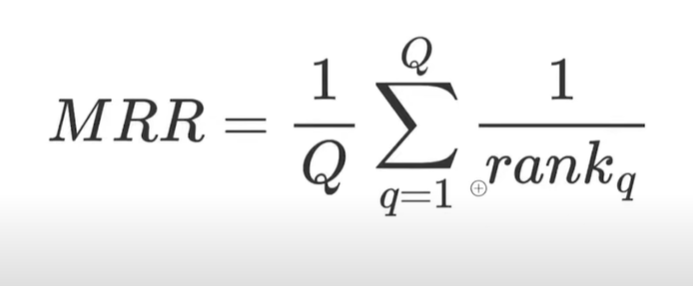

* Advantages of MRR over Recall
1. Order of return is considered!
2. Considers multiple search queries in evaluation.

* Rank Reciprocal
  * Equation above: `1/rankq`
  * Let's say we have 3 separate queries, the rank reciprocal would be:

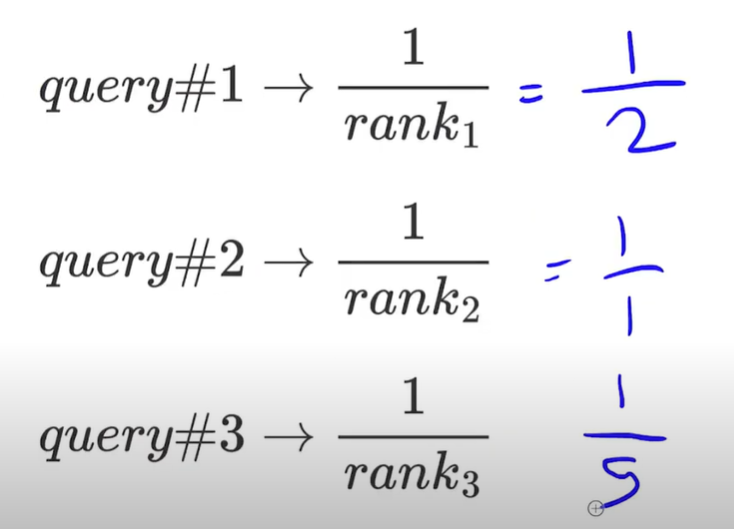



* Next we sum all of the rank reciprocals together:

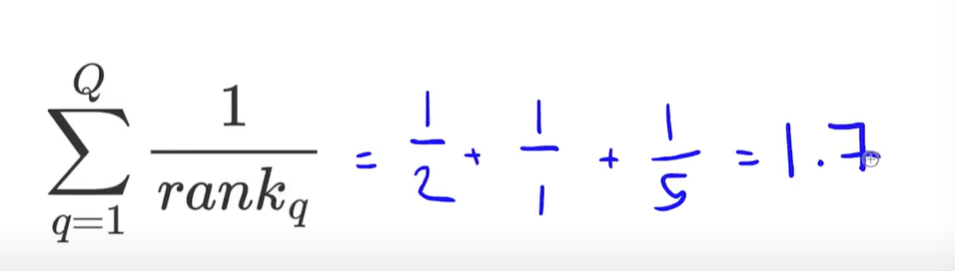

* Next, we divide by the total number of search queries (3), so we get --> 1.7/3

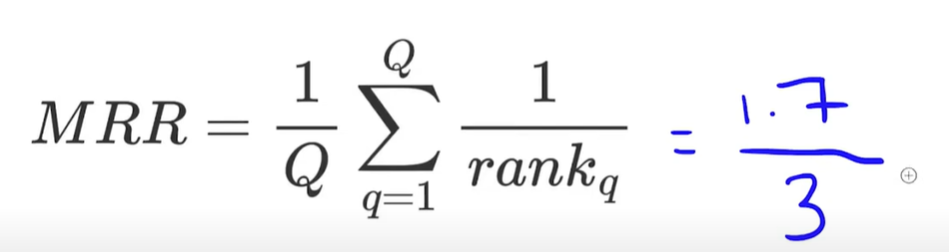

* Thus, the MRR = 0.57

In [3]:
## MRR in python
# relevant results for query #1, #2, #3
actual_relevant = [
    [2,4,5,7],
    [1,4,5,7],
    [5,8]
]

In [4]:
# number of queries
Q = len(actual_relevant)

# calculate reciprocal of 1st relevant actual relevant
reciprocal = 0
# iterate
for i in range(Q):
  first_result = actual_relevant[i][0]
  reciprocal = reciprocal + (1 / first_result)
  print(f"query #{i+1} = 1/{first_result} = {reciprocal}")


# calculate mrr - mean recip based on num of queries (3)
mrr = 1/Q * reciprocal

# generate results
print("MRR =", round(mrr,2))

query #1 = 1/2 = 0.5
query #2 = 1/1 = 1.5
query #3 = 1/5 = 1.7
MRR = 0.57


## 3. `MAP` - mean average precision
* Order aware metric
* Steps
1. Calculate precision@k (see above)
2. Then, calculate average precision@K

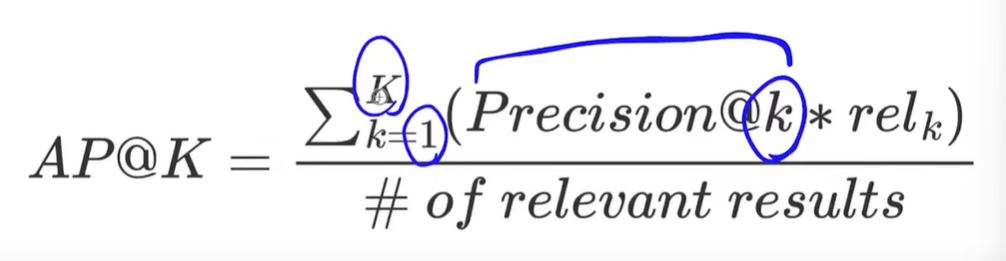

* `relk` - relevance of precision values at k
   * Relevance scores are calculated for each k
      * If relevant score is 1
      * If not relevant, score is 0.

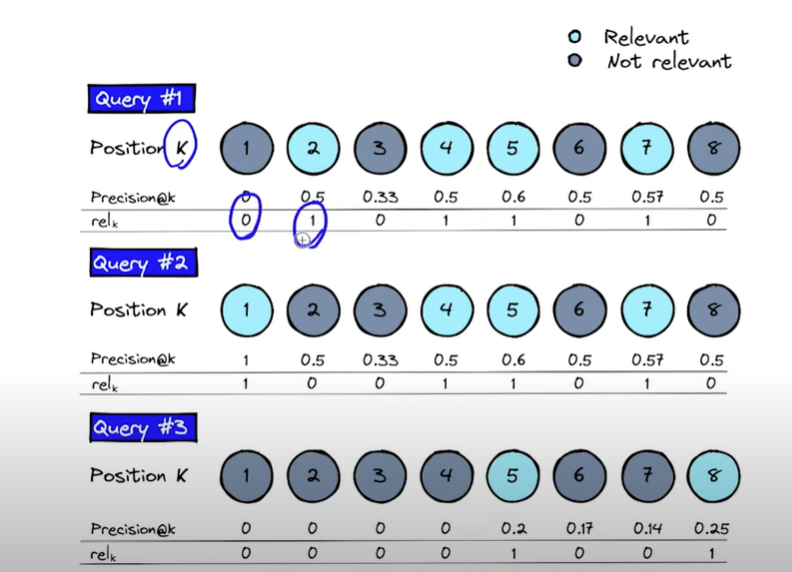

* However, we only calculate the precision where we have a relevant item (1).
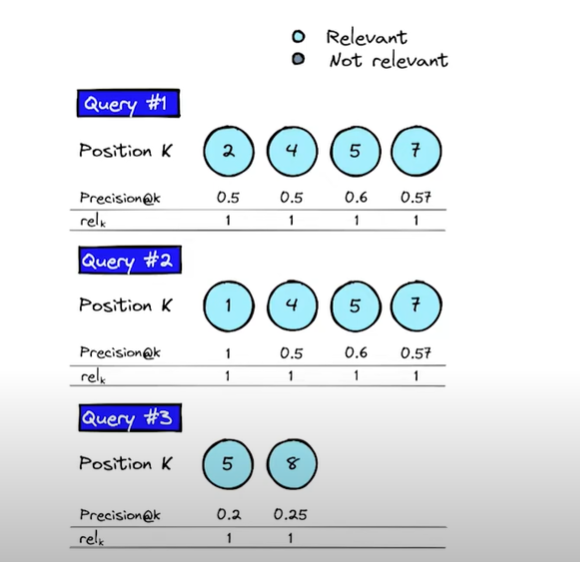

* We divide by the number of relevant results returned.
* MAP is the average over each of the 3 queries that were made.

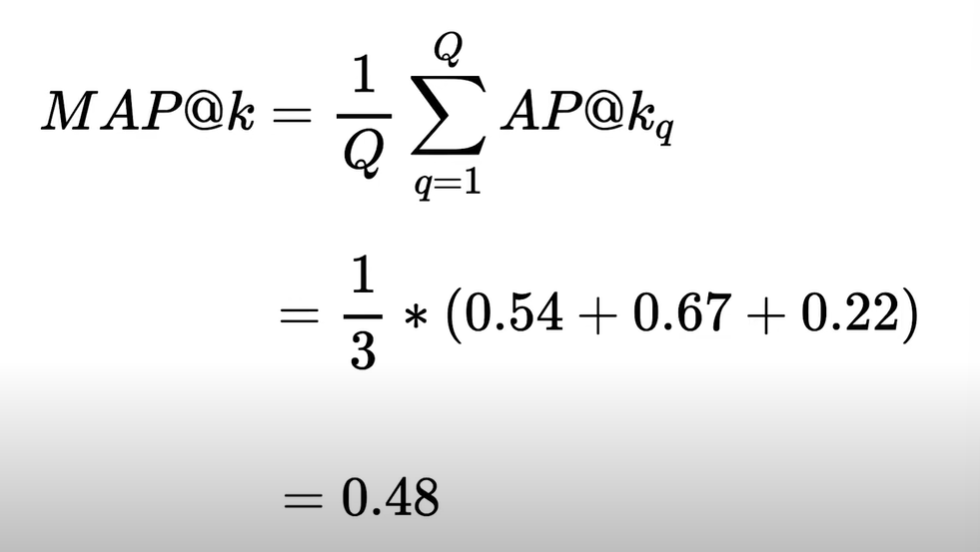

In [7]:
# MAP implemented
# initialize variables
actual = [
    [2,4,5,7],
    [1,4,5,7],
    [5,8]
]

Q = len(actual)
predicted = [1,2,3,4,5,6,7,8]
k=8
ap=[]

# loop through and calculate AP for each query q
for q in range(Q):
  ap_num = 0
  # loop through k vals
  for x in range(k):
    # calcualte precision@k
    act_set = set(actual[q])
    pred_set = set(predicted[:x+1])
    precision_at_k = len(act_set & pred_set) / (x+1)
    # calculate rel_k values
    if predicted[x] in actual[q]:
      rel_k = 1 # relevant is 1
    else:
      rel_k = 0 # not relevant is 0
    # calculate numerator value for ap
    ap_num += precision_at_k * rel_k
    # now calculate AP value as avg of all querie
  # numerator values
  ap_q = ap_num / len(actual[q])
  print(f"AP@{k}_{q+1} = {round(ap_q,2)}")
  ap.append(ap_q)

# now take mean of all ap values to get MAP
map_at_k = sum(ap) / Q

# get results
print(f"mAP@{k} = {round(map_at_k, 2)}")

AP@8_1 = 0.54
AP@8_2 = 0.67
AP@8_3 = 0.23
mAP@8 = 0.48


## 4. `NDCG@k` - Normalized Discounted Cumulative Gain
* Order aware metric.
* The value of NDCG is determined by comparing the relevance of the items returned by the search application to the relevance of the item that a hypothetical “ideal” search would return.
* Start with relevance again, but not the same relevance as before where we noted 0 for not relevant and 1 for relevant.
* Instead, we rank them based on most relevant (4) to least relevant (0).

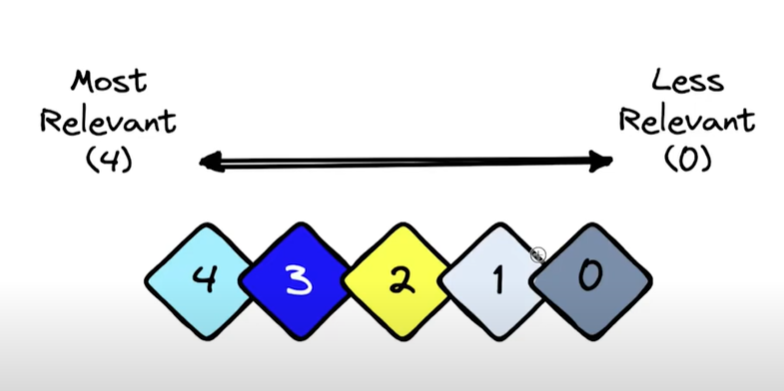

* Scale can vary based on your data, here we are using 0 to 4.
* Labeled data means more specific relevant rankings.


* Start by calculating the cumulative Gain as such:
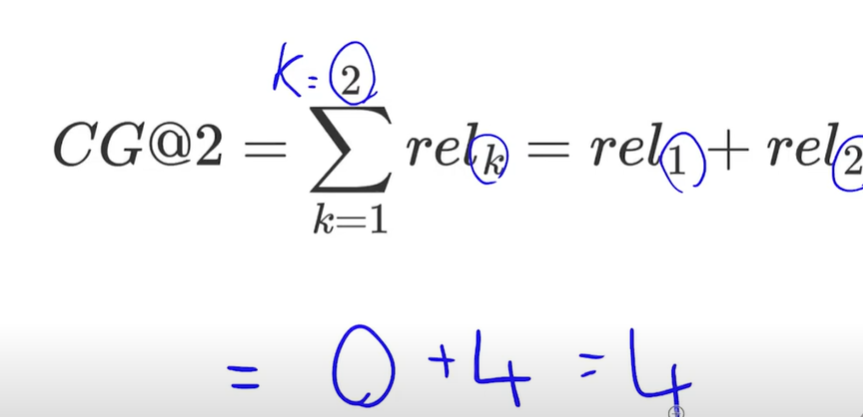

Note: Cumulative Gain by itself is NOT order aware. We have to make it order aware, but how?

Enter the "Discounted Cumulative Gain" or **DCG**.
* The difference is that DCG adds a penalty function (log2) in the denominator.
* DCG calculated for DCG@2:

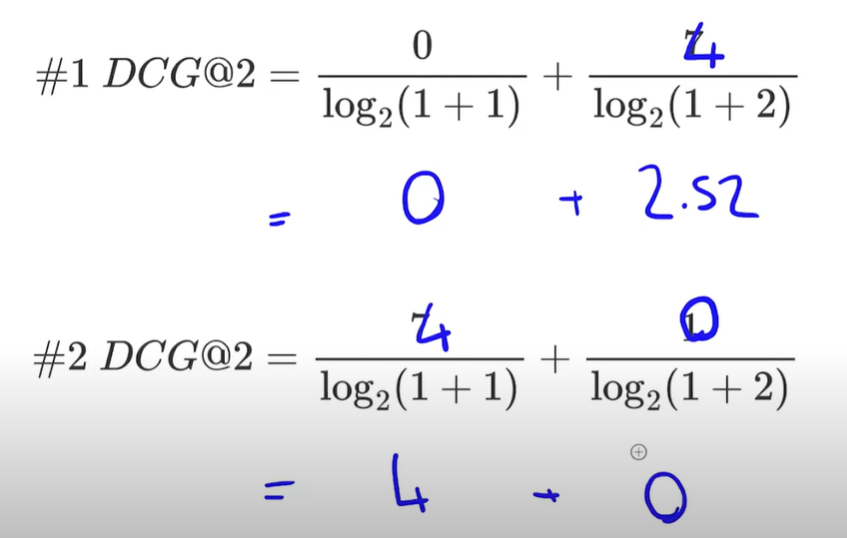


In [8]:
## DCG in python
from math import log2

# init variables
relevance = [0,4,1,3,4,1,3,2]
K = 8

dcg = 0
# loop through each item and calculate DCG
for k in range(1, K+1):
  rel_k = relevance[k-1]
  # calcualte DCG
  dcg += rel_k / log2(1 + k) #log2 is penalty function
  print(f"DCG@{k} = {round(dcg, 2)}")

DCG@1 = 0.0
DCG@2 = 2.52
DCG@3 = 3.02
DCG@4 = 4.32
DCG@5 = 5.86
DCG@6 = 6.22
DCG@7 = 7.22
DCG@8 = 7.85


Problem with DCG
* Values don't really have a range.
* Depends on relevancy range assigned (0 to 4) or whatever you assign.
* Thus the NDCG "normalizes" this, as we can see below the equation for IDCG or "ideal cumulative gain".



In [9]:
# IDCG in python
# sort items in "relevance" from most relevant to less relevant
ideal_relevance = sorted(relevance, reverse=True)

print(ideal_relevance)

# ideal cumulative gain
idcg = 0
# as before, loop through each item and calculate ideal cum gain
for k in range(1, K+1):
  rel_k = ideal_relevance[k-1]
  # calculate DCG
  idcg += rel_k / log2(1 + k)
  print(f"IDCG@{k} = {round(idcg, 2)}")

[4, 4, 3, 3, 2, 1, 1, 0]
IDCG@1 = 4.0
IDCG@2 = 6.52
IDCG@3 = 8.02
IDCG@4 = 9.32
IDCG@5 = 10.09
IDCG@6 = 10.45
IDCG@7 = 10.78
IDCG@8 = 10.78


* Now we can calculate the NDCG which is simply the DCG / IDCG:

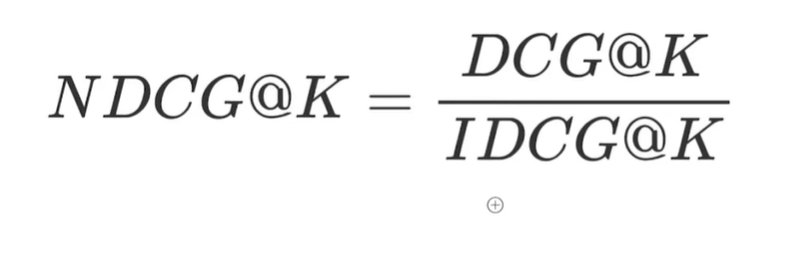

In [10]:
## NDCG calculation
dcg = 0
idcg = 0

for k in range(1, K+1):
  # calculate rel_k values
  rel_k = relevance[k-1]
  ideal_rel_k = ideal_relevance[k-1]
  # calculate dcg and idcg
  dcg += rel_k / log2(1 + k)
  idcg += ideal_rel_k / log2(1 + k)
  # calculate ndcg
  ndcg = dcg / idcg
  print(f"NDCG@{k} = {round(ndcg, 2)}")

NDCG@1 = 0.0
NDCG@2 = 0.39
NDCG@3 = 0.38
NDCG@4 = 0.46
NDCG@5 = 0.58
NDCG@6 = 0.6
NDCG@7 = 0.67
NDCG@8 = 0.73
